<img src="spam.jpg" />

# Spam Classifier

### Objectif : Concevoir un classifieur de détection automatique de SPAM.

La collection SMS Spam est un ensemble de messages SMS marqués qui ont été collectés pour la recherche sur les SMS Spam. Elle contient un ensemble de messages SMS en anglais de 5 574 messages, étiquetés selon qu'ils sont ham (légitimes) ou spam.

## Sommaire

### [EDA](#chapter1)
* [Valeurs en double](#duplicate)
* [Nettoyage de l'encoding](#cleaning_encoding)

### [Features extraction](#features_extraction)
* [Longueur du texte](#length)
* [Nombre de mots](#words_count)
* [Nombre de majuscules](#uppercases_count)
* [Nombre de minuscules](#lowercases_count)
* [Présence d'un numéro de téléphone](#phone_number)
* [Présence d'une url ou d'un mail](#url_or_mail)
* [Nombre de caractères spéciaux](#special_char_count)
* [Wordcloud](#wordcloud)

### [Preprocessing](#preprocessing)
### [Normalise](#normalise)
### [Pipeline ML](#pipeline_ml)
### [Prédiction](#prediction)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import string

In [2]:
df = pd.read_csv('spam.csv',encoding = "latin-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.rename(columns={"v1": "target", "v2": "text"},inplace=True)

In [5]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.describe()

,target,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# EDA <a class="anchor" id="chapter1"></a>

In [7]:
df['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

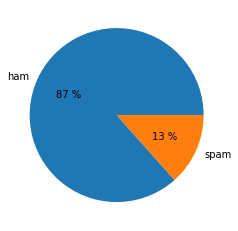

In [8]:
plt.pie(df["target"].value_counts(),labels=["ham","spam"],autopct="%.0f %%")
plt.show()

### Valeurs en double <a class="anchor" id="duplicate"></a>

In [9]:
df.duplicated().value_counts()

False    5169
True      403
dtype: int64

In [10]:
df.drop_duplicates(inplace=True) # Suppression des doublons

In [11]:
df.duplicated().value_counts() # Verification apres suppression

False    5169
dtype: int64

### Nettoyage de l'encoding <a class="anchor" id="cleaning_encoding"></a>

In [12]:
def text_cleaning_encoding(text):
    text = re.sub('&lt;#&gt;',"",text) #Removing square brackets from the text
    return(text) 

In [13]:
df['text'] = df['text'].apply(text_cleaning_encoding)

# Features extraction <a class="anchor" id="features_extraction"></a>

#### Longueur du texte <a class="anchor" id="length"></a>

In [14]:
df['length'] = df['text'].str.len()

In [15]:
df.head() # Verification

,target,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


#### Nombre de mots <a class="anchor" id="words_count"></a>

In [16]:
df['words_count'] = df['text'].apply(lambda x: len(x.split(" ")))

In [17]:
df.head() # Verification

,target,text,length,words_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


#### Nombre de majuscules <a class="anchor" id="uppercases_count"></a>

In [18]:
df['uppercases_count'] = df['text'].str.findall(r'[A-Z]').str.len()

In [19]:
df.head() # Verification

,target,text,length,words_count,uppercases_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3
1,ham,Ok lar... Joking wif u oni...,29,6,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10
3,ham,U dun say so early hor... U c already then say...,49,11,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2


#### Nombre de minuscules <a class="anchor" id="lowercases_count"></a>

In [20]:
df['lowercases_count'] = df['text'].str.findall(r'[a-z]').str.len()

In [21]:
df.head()

,target,text,length,words_count,uppercases_count,lowercases_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80
1,ham,Ok lar... Joking wif u oni...,29,6,2,16
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87
3,ham,U dun say so early hor... U c already then say...,49,11,2,31
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45


#### Presence d'un numéro de téléphone <a class="anchor" id="phone_number"></a>

In [22]:
def isNumberSequenceInText(txt):
    if bool(re.search("(\d{2})", txt)):
        return 1
    else:
        return 0

In [23]:
df['number_sequence'] = df['text'].map(isNumberSequenceInText)

In [24]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0


In [25]:
df.groupby(['target'])['number_sequence'].sum()

target
ham      97
spam    580
Name: number_sequence, dtype: int64

Text(0.5, 1.0, 'le rapport ham/spam quand il y a au mois 2 chiffres de suites')

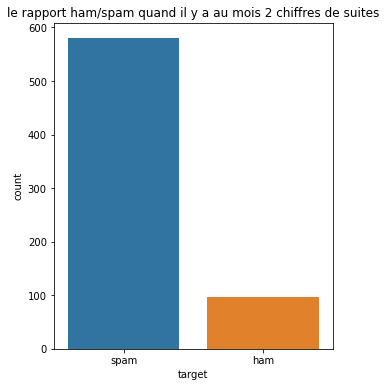

In [26]:
df1 = df[df['number_sequence'] == 1]
plt.figure(figsize=(5,6),)
sns.countplot(x=df1['target']).set_title('le rapport ham/spam quand il y a au mois 2 chiffres de suites')

#### Présence d'une url ou d'un mail <a class="anchor" id="url_or_mail"></a>

In [27]:
# Ancien ReGex -> \.[a-z]{2,3}(\.|\s|$)|(https?:\/\/|www\.)[a-zA-Z0-9-_\.]+

def isUrlMailInText(txt):
    if bool(re.search("((https?:\/\/|www\.)[a-zA-Z0-9-_\.]+)|(\w+@\w+)", txt)):
        return 1
    else:
        return 0

In [28]:
df['url_or_mail'] = df['text'].map(isUrlMailInText)

In [29]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1,0
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0,0


In [30]:
df.groupby(['target'])['url_or_mail'].sum()

target
ham       2
spam    103
Name: url_or_mail, dtype: int64

Text(0.5, 1.0, "Rapport ham/spam si présence d'une url ou d'un mail")

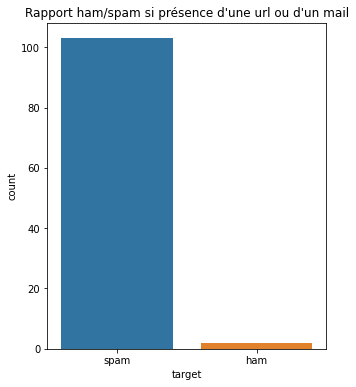

In [31]:
df1 = df[df['url_or_mail'] == 1]
plt.figure(figsize=(5,6),)
sns.countplot(x=df1['target']).set_title('Rapport ham/spam si présence d\'une url ou d\'un mail')

#### Nombre de caractères spéciaux <a class="anchor" id="special_char_count"></a>

In [32]:
# Modification de la fonction pour sortir des catégories
# categorie : nb de caracteres speciaux
# cat 1 : [1]
# cat 2 : [2-6]
# cat 3 : [7-12]
# cat 4 : [13+]

def countSpecialCharInText(txt):
    category = 0
    nbSpecialChar = len(re.findall("[$&+:;=?@#|'<>^*()%!-]", txt))
    if nbSpecialChar == 1:
        category = 1
    elif nbSpecialChar > 1 and nbSpecialChar < 7:
        category = 2
    elif nbSpecialChar > 6 and nbSpecialChar < 13:
        category = 3
    elif nbSpecialChar > 12:
        category = 4
        
    return category

In [33]:
df['special_char_count'] = df['text'].map(countSpecialCharInText)

In [34]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail,special_char_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1,0,2
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0,0,1


In [35]:
df[df['special_char_count'] == 0]

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail,special_char_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0,0
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0,0
6,ham,Even my brother is not like to speak with me. ...,77,16,2,58,0,0,0
17,ham,Eh u remember how 2 spell his name... Yes i di...,81,19,3,54,0,0,0
...,...,...,...,...,...,...,...,...,...
5561,ham,Get me out of this dump heap. My mom decided t...,70,15,8,45,0,0,0
5562,ham,Ok lor... Sony ericsson salesman... I ask shuh...,96,18,3,66,0,0,0
5563,ham,Ard 6 like dat lor.,19,5,1,12,0,0,0
5565,ham,Huh y lei...,12,3,1,6,0,0,0


In [36]:
cTabSpecialChar = pd.crosstab(df['target'], df['special_char_count'])

In [37]:
cTabSpecialChar

special_char_count,0,1,2,3,4
target,,,,,
ham,1933,1280,1219,74,10
spam,110,134,386,18,5


<AxesSubplot:xlabel='special_char_count', ylabel='Count'>

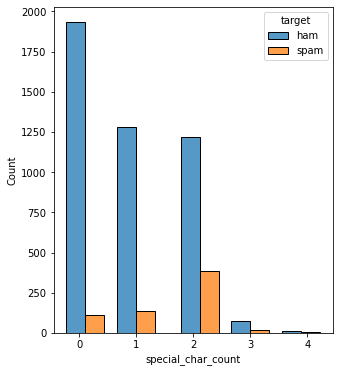

In [38]:
plt.figure(figsize=(5,6),)
sns.histplot(data=df, x="special_char_count", hue="target", multiple="dodge", shrink=3)

# Wordcloud <a class="anchor" id="wordcloud"></a>

#### Préparation

In [39]:
def text_cleaning(text):
    text = str(text).lower() #Converting text into lowercase
    text = re.sub('\[.*?\]','',text) #Removing square brackets from the text
    text = re.sub('https?://\S+|www\.\S+', '', text) #Removing links starting with (https or www)
    text = re.sub('<.*?>+','',text) #Removing <"text"> type of text
    text = re.sub("[%s]" % re.escape(string.punctuation),'',text) #Removing punctuations
    text = re.sub("\n",'',text) #Removing new lines
    text = re.sub('\w*\d\w*','',text) #Removing alphanumeric numbers
    text = re.sub('û÷',"'",text) # Remplacement caractères non encodés
    text = re.sub('åõ',"'",text) # Remplacement caractères non encodés
    return(text)

In [40]:
df['text'] = df['text'].apply(text_cleaning)

In [41]:
strHam = ""
strSpam = ""

for idx, series in df.iterrows():
    if series['target'] == 'ham': 
        strHam += series['text']
        strHam += " "
    else:
        strSpam += series['text']
        strSpam += " "

In [42]:
df['text'].head(25)

0     go until jurong point crazy available only in ...
1                               ok lar joking wif u oni
2     free entry in  a wkly comp to win fa cup final...
3           u dun say so early hor u c already then say
4     nah i dont think he goes to usf he lives aroun...
5     freemsg hey there darling its been  weeks now ...
6     even my brother is not like to speak with me t...
7     as per your request melle melle oru minnaminun...
8     winner as a valued network customer you have b...
9     had your mobile  months or more u r entitled t...
10    im gonna be home soon and i dont want to talk ...
11    six chances to win cash from  to  pounds txt  ...
12    urgent you have won a  week free membership in...
13    ive been searching for the right words to than...
14                    i have a date on sunday with will
15    xxxmobilemovieclub to use your credit click th...
16                                 oh kim watching here
17    eh u remember how  spell his name yes i di

In [43]:
strHam

"go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat ok lar joking wif u oni u dun say so early hor u c already then say nah i dont think he goes to usf he lives around here though even my brother is not like to speak with me they treat me like aids patent as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press  to copy your friends callertune im gonna be home soon and i dont want to talk about this stuff anymore tonight k ive cried enough today ive been searching for the right words to thank you for this breather i promise i wont take your help for granted and will fulfil my promise you have been wonderful and a blessing at all times i have a date on sunday with will oh kim watching here eh u remember how  spell his name yes i did he v naughty make until i v wet fine if that's the way u feel that's the way its gota b is that seriously how you spell his name i\x89'm going

<Figure size 432x288 with 0 Axes>

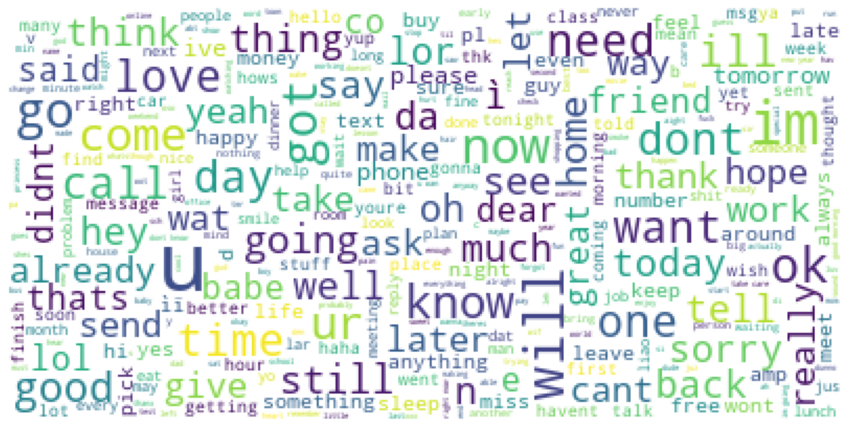

In [44]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate(strHam)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(strHam),max_font_size=40, relative_scaling=.5).generate(strHam)
plt.figure()
plt.figure( figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Wordcloud des Spam

<Figure size 432x288 with 0 Axes>

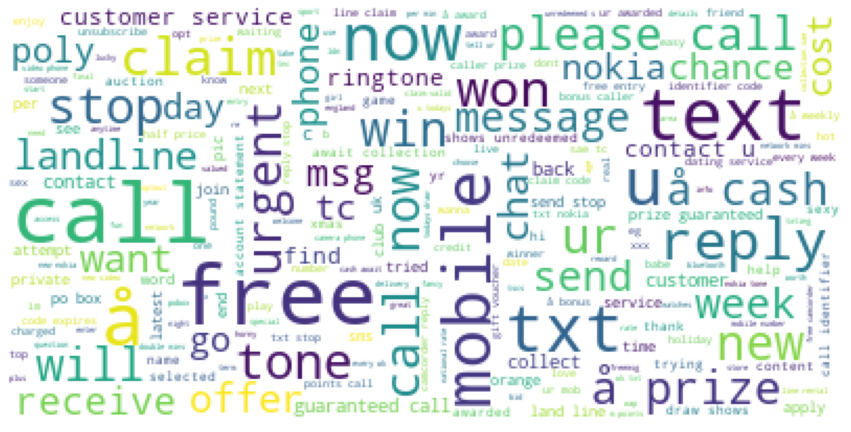

In [45]:
# Generate a word cloud image
wordcloud = WordCloud().generate(strSpam)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(strSpam),max_font_size=40, relative_scaling=.5).generate(strSpam)
plt.figure()
plt.figure( figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

prize, urgent, free, mobile, please call, call now, cash, chat, win, txt, now, reply, phone, new, now, call, tone, claim, won, chance 

In [46]:
wordsList = ['prize','urgent','free','mobile','please','cash','chat','win','txt','reply','phone','new','now','call','tone','claim','won','chance']

In [47]:
def countWordsInText(txt):
    res = 0
    nb = 0
    for i in wordsList:
        nb += len(re.findall(r"\b" + i + r"\b", txt))
            
    if nb > 3:
        res = 1
    else:
        res = 0

    return res

In [48]:
for r in df['text']:
    print("-- ",r,countWordsInText(r))

--  go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat 0
--  ok lar joking wif u oni 0
--  free entry in  a wkly comp to win fa cup final tkts  may  text fa to  to receive entry questionstd txt ratetcs apply  0
--  u dun say so early hor u c already then say 0
--  nah i dont think he goes to usf he lives around here though 0
--  freemsg hey there darling its been  weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send å£ to rcv 0
--  even my brother is not like to speak with me they treat me like aids patent 0
--  as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press  to copy your friends callertune 0
--  winner as a valued network customer you have been selected to receivea å£ prize reward to claim call  claim code  valid  hours only 1
--  had your mobile  months or more u r entitled to update to the latest colour mobiles with camer

--  do you realize that in about  years well have thousands of old ladies running around with tattoos 0
--  you have an important customer service announcement from premier 0
--  dont gimme that lip caveboy 0
--  when did you get to the library 0
--  realy sorryi dont recognise this number and am now confused  who r u please  0
--  so why didnt you holla 0
--  cant think of anyone with  spare room off  top of my head 0
--  faith makes things possiblehope makes things worklove makes things beautifulmay you have all three this christmasmerry christmas 0
--  u should have made an appointment 0
--  call me when youcarlos isare here my phones vibrate is acting up and i might not hear texts 0
--  romantic paris  nights  flights from å£ book now  next year call  apply 0
--  we are at grandmas oh dear u still ill i felt shit this morning but i think i am just hungover another night then we leave on sat 0
--  urgent ur å£ guaranteed award is still unclaimed call  now  claimcode  å£ 0
--  nothin

--  there are no other charges after transfer charges and you can withdraw anyhow you like 0
--  dont search love let love find u thats why its called falling in love bcoz u dont force yourself u just fall and u know there is smeone to hold u bslvyl 0
--  at  lets go to bill millers 0
--  i love you you set my soul on fire it is not just a spark but it is a flame a big rawring flame xoxo 0
--  somewhr someone is surely made  u and god has decided a perfect time to make u meet dat person    till den      enjoy ur crushes 0
--  thats my honeymoon outfit  0
--  will it help if we propose going back again tomorrow 0
--  private your  account statement for shows  unredeemed s i m points call  identifier code  expires  0
--  never blame a day in ur life good days give u happiness bad days give u experience both are essential in life all are gods blessings good morning 0
--  pls confirm the time to collect the cheque 0
--  as a registered subscriber yr draw  a å£ gift voucher will b entered o

--  onum ela pa normal than 0
--  kkhow is your sister kids 0
--  cool ill text you when im on the way 0
--  nope meanwhile she talk say make i greet you 0
--  i cant talk to you nowi will call when i candont keep calling 0
--  anything lar 0
--  rose needs water season needs change poet needs imaginationmy phone needs ur sms and i need ur lovely frndship forever 0
--  good afternoon babe how goes that day  any job prospects yet  i miss you my love  sighs   0
--  they will pick up and drop in carso no problem 0
--  si think he is waste for rr 0
--  he is world famamus 0
--  is there coming friday is leave for pongaldo you get any news from your work place 0
--  lol well dont do it without me we could have a big sale together 0
--   am on my way 0
--  eat at old airport road but now  oredi got a lot of pple 0
--  sry cant talk on phone with parents 0
--  ok lor wat time ì finish 0
--  princess i like to make love    times per night hope thats not a problem 0
--  mm i am on the way to ra

--    do you want a new nokia  colour phone deliveredtomorrow with  free minutes to any mobile   free texts  free camcorder reply or call  1
--  tap  spile at seven  is that pub on gas st off broad st by canal ok 0
--  ok then i come n pick u at engin 0
--  which is why i never wanted to tell you any of this which is why im so short with you and onedge as of late 0
--  raviyog peripherals bhayandar east 0
--  k actually can you guys meet me at the sunoco on howard it should be right on the way 0
--  moon has come to color your dreams stars to make them musical and my sms to give you warm and peaceful sleep good night 0
--  just finished eating got u a plate not leftovers this time 0
--  thanx a lot 0
--  hurry home u big butt hang up on your last caller if u have to food is done and im starving dont ask what i cooked 0
--  lol your right what diet everyday i cheat anyway im meant to be a fatty  0
--  its a great day do have yourself a beautiful one 0
--  what happened in interview 0
--

--  double eviction this week  spiral and michael and good riddance to them 0
--  the world suffers a lot not because of the violence of bad people but because of the silence of good people 0
--  ok thats cool its  just off either raglan rd or edward rd behind the cricket ground gimme ring when ur closeby see you tuesday 0
--  buy one egg for me daplease 0
--  have you started in skye 0
--  have you bookedthe hut and also your time off how are you by the way 0
--  and several to you sir 0
--  u really pig leh sleep so much my dad wake me up at  smth  eat lunch today 0
--  my love  i hope your not doing anything drastic dont you dare sell your pc or your phone  0
--  freemsg our records indicate you may be entitled to  pounds for the accident you had to claim for free reply with yes to this msg to opt out text stop 0
--  life style garments account no please 0
--  lol wtf random btw is that your lunch break 0
--  sez hows u  de arab boy hope u r all good give my love   love ya eshxxxxxx

--  this is the  attempt to contract u you have won this weeks top prize of either å£ cash or å£ prize just call  1
--  well im glad you didnt find it totally disagreeable  lol 0
--  guy no flash me now if you go call me call me how madam take care oh 0
--  do you want a new nokia  colour phone deliveredtomorrow with  free minutes to any mobile   free texts  free camcorder reply or call  1
--  mark works tomorrow he gets out at  his work is by your house so he can meet u afterwards 0
--  keep ur problems in ur heart 0
--  yeah give me a call if youve got a minute 0
--  hi babe uawakefeellikw shitjustfound out via aletter thatmum gotmarried  ourbacks åð fuckinniceselfish 0
--  amazing  if you rearrange these letters it gives the same meaning dormitory  dirty room astronomer  moon starer the eyes  they see election results  lies lets recount motherinlaw  woman hitler eleven plus two twelve plus one its amazing  0
--  aiya we discuss later lar pick ì up at  is it 0
--  hey happy birthday 

In [49]:
df['words_fateful_count'] = df['text'].map(countWordsInText)

In [50]:
df.groupby(['target'])['words_fateful_count'].sum()

target
ham       5
spam    176
Name: words_fateful_count, dtype: int64

# Preprocessing <a class="anchor" id="preprocessing"></a>

In [54]:
df.head()

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail,special_char_count,words_fateful_count
0,ham,go until jurong point crazy available only in ...,111,20,3,80,0,0,0,0
1,ham,ok lar joking wif u oni,29,6,2,16,0,0,0,0
2,spam,free entry in a wkly comp to win fa cup final...,155,28,10,87,1,0,2,0
3,ham,u dun say so early hor u c already then say,49,11,2,31,0,0,0,0
4,ham,nah i dont think he goes to usf he lives aroun...,61,13,2,45,0,0,1,0


In [55]:
#df.drop('text',axis=1,inplace=True)

In [56]:
"""
from sklearn.preprocessing import LabelEncoder

# target preprocessing
lb_encod = LabelEncoder()
y = lb_encod.fit_transform(df['target'])
"""

In [57]:
"""
# features preprocessing
#X = df.drop(columns='target')
X = df.drop(columns=['target','special_char_count','words_fateful_count'])
X.head()
"""

,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail
0,111,20,3,80,0,0
1,29,6,2,16,0,0
2,155,28,10,87,1,0
3,49,11,2,31,0,0
4,61,13,2,45,0,0


# Normalise <a class="anchor" id="normalise"></a>

In [58]:
"""
# Selection des colonnes a normaliser
#column_num = ['length','words_count','uppercases_count','lowercases_count','special_char_count','words_fateful_count']
column_num = ['length','words_count','uppercases_count','lowercases_count']
"""

Recherche d'un scaler

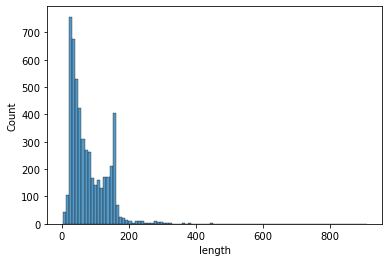

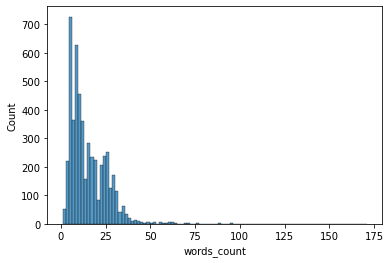

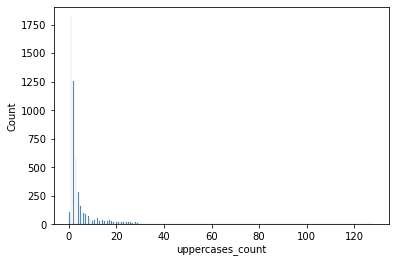

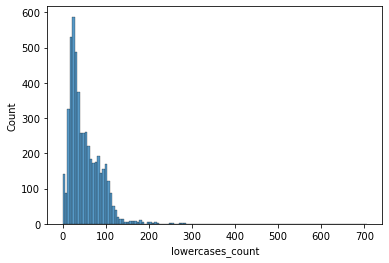

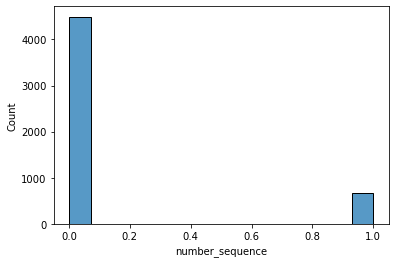

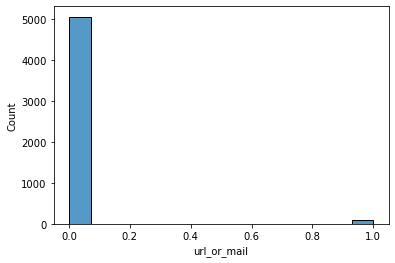

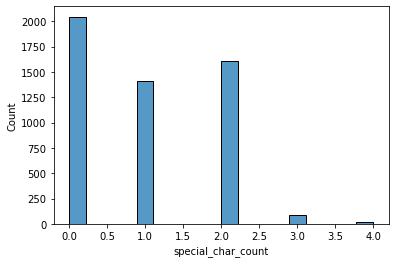

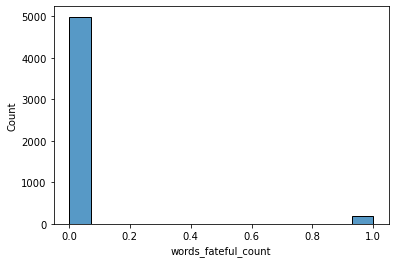

In [59]:
# Distribution
for col in df[df.columns.drop('target')]:
    plt.figure()
    sns.histplot(df[col])

In [60]:
"""
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

transfo_num = Pipeline(steps=[('scaling', MinMaxScaler())])
"""

# Pipeline ML <a class="anchor" id="pipeline_ml"></a>

In [61]:
"""
from sklearn.compose import ColumnTransformer

# Class ColumnTransformer : apply alls steps on the whole dataset
preparation = ColumnTransformer(transformers=[('data_num', transfo_num , column_num)])
"""

In [62]:
"""
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Creation of model : a ready to use pipeline for ML process
model = DecisionTreeClassifier(max_depth=5)
model1 = RandomForestClassifier(max_depth=5, random_state=0)
pipe_model = Pipeline(steps=[
    ('preparation', preparation),
    ('DecisionTreeClassifier',model)
])
pipe_model
"""

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_num',
                                                  Pipeline(steps=[('scaling',
                                                                   MinMaxScaler())]),
                                                  ['length', 'words_count',
                                                   'uppercases_count',
                                                   'lowercases_count'])])),
                ('DecisionTreeClassifier',
                 DecisionTreeClassifier(max_depth=5))])

In [63]:
"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
"""

In [64]:
#pipe_model.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_num',
                                                  Pipeline(steps=[('scaling',
                                                                   MinMaxScaler())]),
                                                  ['length', 'words_count',
                                                   'uppercases_count',
                                                   'lowercases_count'])])),
                ('DecisionTreeClassifier',
                 DecisionTreeClassifier(max_depth=5))])

### Prédiction <a class="anchor" id="prediction"></a>

In [65]:
#y_pred = pipe_model.predict(X_test)

In [66]:
"""
from sklearn.metrics import accuracy_score
# Score of models
score = accuracy_score(y_test, y_pred)
print("score :", round(score, 5))
"""

score : 0.94584


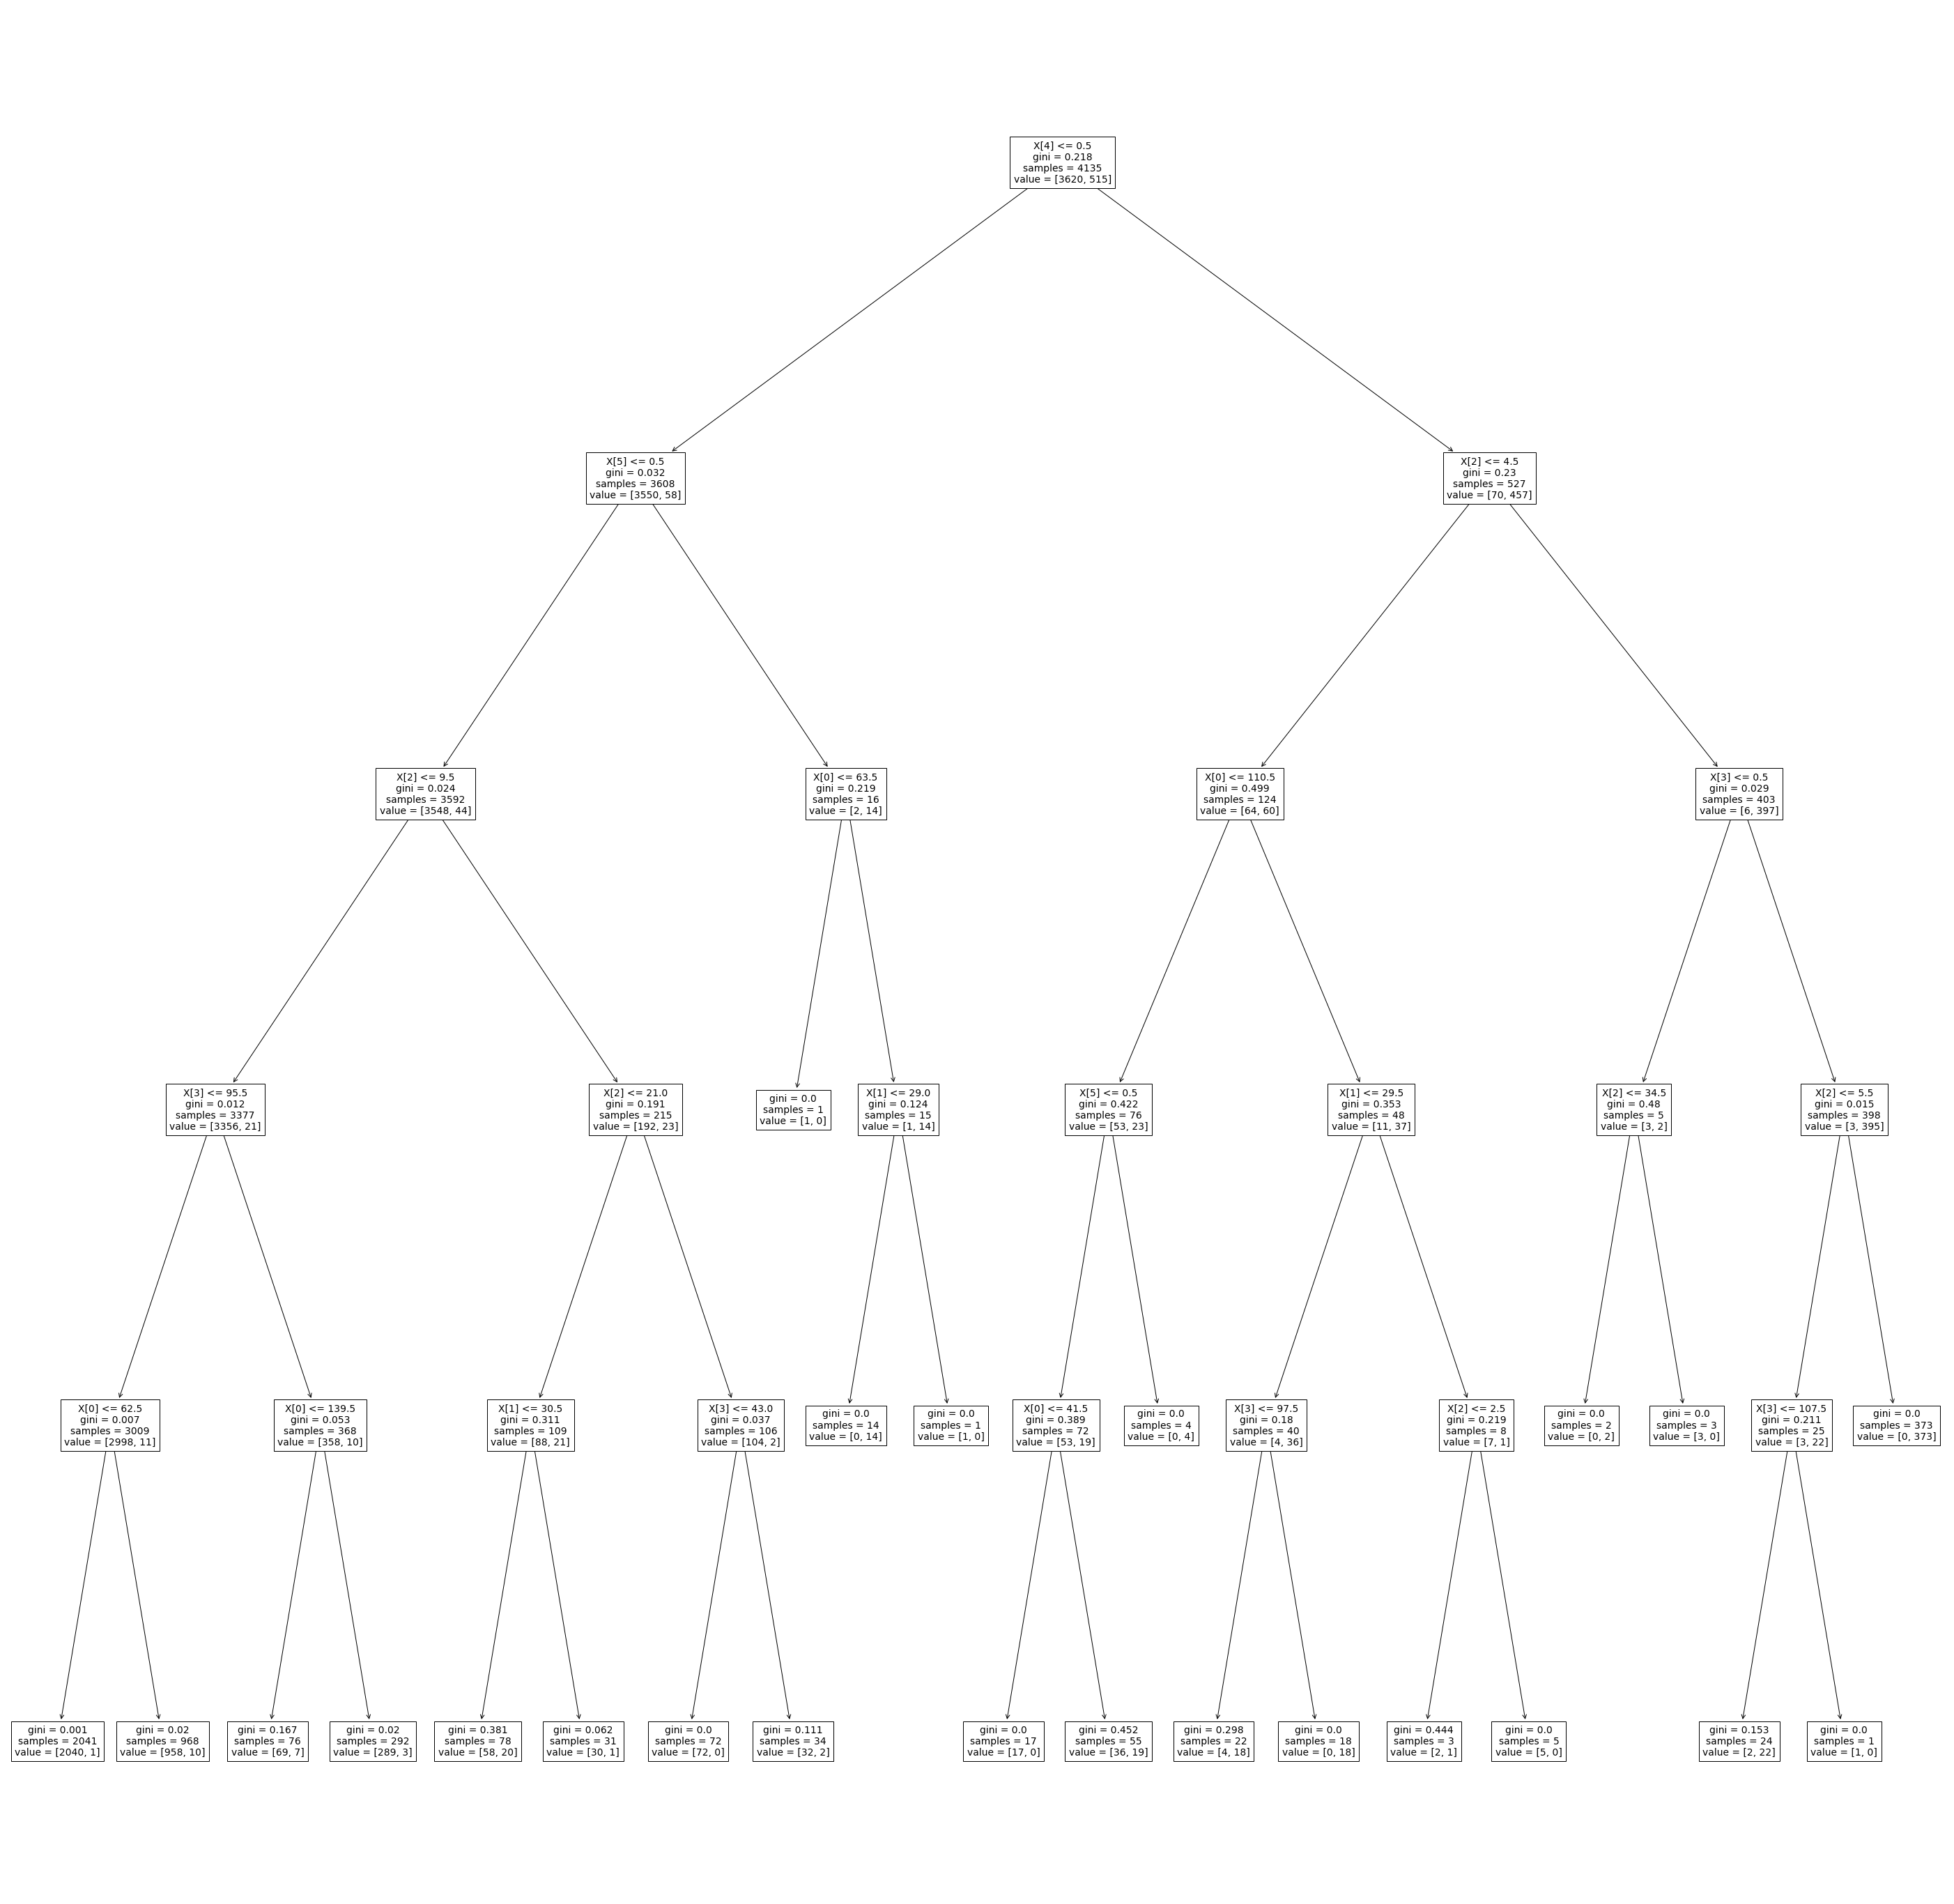

In [67]:
"""
from sklearn import tree
# Step 1: Import the model you want to use
# This was already imported earlier in the notebook so commenting out
# Step 2: Make an instance of the Model
clf = tree.DecisionTreeClassifier(max_depth=5)
# Step 3: Train the model on the data
clf.fit(X_train, y_train)
# Step 4: Predict labels of unseen (test) data
# Not doing this step in the tutorial
# clf.predict(X_test)

plt.figure( figsize=(50,50))
tree.plot_tree(clf);
"""

In [68]:
X_train.columns

Index(['length', 'words_count', 'uppercases_count', 'lowercases_count',
       'number_sequence', 'url_or_mail'],
      dtype='object')

In [69]:
#Export de l'arbre
"""
from sklearn.tree import export_graphviz

export_graphviz(
    pipe_model,
    out_file=None,
    feature_names=df.columns[1:],
    class_names='target',
    rounded=True,
    filled=True
)
"""

"\nfrom sklearn.tree import export_graphviz\n\nexport_graphviz(\n    pipe_model,\n    out_file=None,\n    feature_names=df.columns[1:],\n    class_names='target',\n    rounded=True,\n    filled=True\n)\n"

# Construction des classes pour App web

Regression logistique
SVM
Arbre de decision
Xgboost
naives bayes
Reseau de neuronnes

In [82]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

class Preprocess():
    
    # Attribut de classe
    wordsList = ['prize','urgent','free','mobile','please','cash','chat','win','txt','reply','phone','new',
        'now','call','tone','claim','won','chance']
    
    # constructeur
    def __init__(self,df):
        self.df_ = df
        self.df_['text'] = self.df_['text'].apply(self.text_cleaning_encoding)
        self.df_['length'] = self.df_['text'].str.len()
        self.df_['words_count'] = self.df_['text'].apply(lambda x: len(x.split(" ")))
        self.df_['uppercases_count'] = self.df_['text'].str.findall(r'[A-Z]').str.len()
        self.df_['lowercases_count'] = self.df_['text'].str.findall(r'[a-z]').str.len()
        self.df_['number_sequence'] = self.df_['text'].map(self.isNumberSequenceInText)
        self.df_['url_or_mail'] = self.df_['text'].map(self.isUrlMailInText)
        self.df_['special_char_count'] = self.df_['text'].map(self.countSpecialCharInText)
        self.df_['words_fateful_count'] = self.df_['text'].map(self.countWordsInText)
        
        # Suppresion de la colonne text, inutile pour le ML
        self.df_.drop('text',axis=1,inplace=True)
        
        # Preparation des features et de la target pour entrainement
        # ------------------------
        # Est-ce le dataframe d'entrainement ou celui de la prediction ?
        self.y = None # Pas de target si c'est pour une prediction
        if 'target' in self.df_.columns:
            self.X = self.df_.drop(columns=['target','special_char_count','words_fateful_count'])
            
            # et encodage de la target (1 ou 0)
            self.lb_encod = LabelEncoder()
            self.y = lb_encod.fit_transform(self.df_['target'])
            
        else:
            self.X = self.df_.drop(columns=['special_char_count','words_fateful_count'])
        
        # Preparation des colonnes pour normalisation
        self.column_num = ['length','words_count','uppercases_count','lowercases_count']
        self.transfo_num = Pipeline(steps=[('scaling', MinMaxScaler())])
        

    def text_cleaning_encoding(self,text):
        text = re.sub('&lt;#&gt;',"",text) #Removing square brackets from the text
        return(text) 
        
    def isNumberSequenceInText(self,txt):
        if bool(re.search("(\d{2})", txt)):
            return 1
        else:
            return 0

    def isUrlMailInText(self,txt):
        if bool(re.search("((https?:\/\/|www\.)[a-zA-Z0-9-_\.]+)|(\w+@\w+)", txt)):
            return 1
        else:
            return 0


    def countSpecialCharInText(self,txt):
        category = 0
        nbSpecialChar = len(re.findall("[$&+:;=?@#|'<>^*()%!-]", txt))
        if nbSpecialChar == 1:
            category = 1
        elif nbSpecialChar > 1 and nbSpecialChar < 7:
            category = 2
        elif nbSpecialChar > 6 and nbSpecialChar < 13:
            category = 3
        elif nbSpecialChar > 12:
            category = 4

        return category

    def countWordsInText(self,txt):
        res = 0
        nb = 0
        for i in Preprocess.wordsList:
            nb += len(re.findall(r"\b" + i + r"\b", txt))

        if nb > 3:
            res = 1
        else:
            res = 0

        return res
    
    def getDf(self):
        return self.df_
    
    def getPipeline(self):
        return self.transfo_num
    
    def getFeatures(self):
        return self.X
    
    def getTarget(self):
        return self.y

In [84]:
# Creation d'un nouveau dataframe
df_predict = pd.DataFrame()
df_predict['text'] = ['Even my brother is not like to speak with me. They treat me like aids patent.']
preprocess = Preprocess(df_predict)
df_new = preprocess.getDf() 
X_new = preprocess.getFeatures()

In [88]:
X_new

,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail
0,77,16,2,58,0,0


In [71]:
class ModelEvaluation():
    
    # constructeur
    def __init__(self,preparation,model):
        self.model = model
        self.preparation = preparation
        self.pipe_m = None
        self.y_pred = None
        self.score = 0
        self.createPipeline()
        self.fitModel()
        self.predict()
        self.showScore()
        
    def createPipeline(self):
        self.pipe_m = Pipeline(steps=[
            ('preparation', preparation),
            ('model',self.model)
        ])
        self.pipe_m
        
    def fitModel(self):
        self.pipe_m.fit(X_train, y_train)
    
    def predict(self):
        self.y_pred = self.pipe_m.predict(X_test)
        
    def showScore(self):
        self.score = accuracy_score(y_test, self.y_pred)
        print(self.model,"score :", round(self.score, 5))

In [ ]:
DesicionTree = ModelEvaluation(preparation,DecisionTreeClassifier(max_depth=5))

In [72]:
X_test

,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail
2461,15,2,1,10,0,0
4673,25,5,1,18,0,0
4822,7,2,0,0,0,0
4174,71,14,3,52,0,0
5058,145,24,9,87,1,0
...,...,...,...,...,...,...
2976,26,6,1,18,0,0
2411,27,6,2,19,0,0
4691,154,30,5,114,0,0
5384,161,31,7,113,0,0


In [73]:
df_new

,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail,special_char_count,words_fateful_count
0,Even my brother is not like to speak with me. ...,77,16,2,58,0,0,0,0
